In [6]:
import warnings
warnings.filterwarnings('ignore')

## Petrophysics calculation

In [7]:
import lasio
las = lasio.read('well-1.las') 

#convert the las file to pandas dataframe, this will automatically retain the logname and made the depth as index column
well=las.df()
display(well)

,CALI,DT,GR,ILD,MSFL,NPHI_LS,RHOB
DEPTH,,,,,,,
3001.0,9.984,148.500,80.875,0.722,0.991,0.43701,2.170
3001.5,9.938,148.625,80.875,0.718,1.026,0.47705,2.176
3002.0,9.914,146.125,80.625,0.714,0.990,0.45947,2.166
3002.5,9.859,145.375,82.625,0.715,0.953,0.47754,2.158
3003.0,9.914,145.125,81.938,0.709,0.900,0.45508,2.156
...,...,...,...,...,...,...,...
4458.0,8.484,109.000,79.812,1.122,1.744,0.33252,2.316
4458.5,8.469,109.438,82.312,1.112,1.972,0.34082,2.326
4459.0,8.484,109.562,77.188,1.092,1.959,0.35693,2.316


In [8]:
KujungFM=well.loc[3337.79:3751.5]
display(KujungFM)

,CALI,DT,GR,ILD,MSFL,NPHI_LS,RHOB
DEPTH,,,,,,,
3338.0,8.617,123.625,88.812,1.006,1.292,0.48193,2.264
3338.5,8.562,116.875,79.500,1.182,1.258,0.46924,2.320
3339.0,8.594,100.000,68.562,1.417,1.250,0.37354,2.408
3339.5,8.492,83.938,51.500,1.742,1.430,0.21143,2.562
3340.0,8.297,65.750,33.844,2.174,7.311,0.13428,2.668
...,...,...,...,...,...,...,...
3749.5,8.555,130.625,85.000,0.773,0.873,0.43115,2.184
3750.0,8.648,130.875,87.500,0.772,0.891,0.43164,2.170
3750.5,8.680,130.875,86.250,0.775,1.158,0.44092,2.178


In [9]:
#this code is adapted from andy mcdonald

def shale_volume(gamma_ray, gamma_ray_max, gamma_ray_min): #specify the arguments
    vshale = (gamma_ray - gamma_ray_min) / (gamma_ray_max - gamma_ray_min) #use the argument to the equation using math operators
    return round(vshale, 4)

def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

In [10]:
mDens= 2.65
fDens= 1
KujungFM['VSHALE']=shale_volume(KujungFM['GR'], KujungFM['GR'].quantile(q=0.99),
                             KujungFM['GR'].quantile(q=0.01))
KujungFM['PHI']=density_porosity(KujungFM['RHOB'], mDens, fDens)
KujungFM.head()

,CALI,DT,GR,ILD,MSFL,NPHI_LS,RHOB,VSHALE,PHI
DEPTH,,,,,,,,,
3338.0,8.617,123.625,88.812,1.006,1.292,0.48193,2.264,0.8678,0.2339
3338.5,8.562,116.875,79.500,1.182,1.258,0.46924,2.320,0.7119,0.2000
3339.0,8.594,100.000,68.562,1.417,1.250,0.37354,2.408,0.5289,0.1467
3339.5,8.492,83.938,51.500,1.742,1.430,0.21143,2.562,0.2433,0.0533
3340.0,8.297,65.750,33.844,2.174,7.311,0.13428,2.668,-0.0522,-0.0109


### Calculate RW and SW

**Apparent water formation resistivity using Hingle method**
<img src="rw.png">

**SW:**
<img src="sw_archie.png">

In [11]:
def rw_app(porosity, archieA, archieM, rt):
    rw= (porosity**archieM * rt/archieA)
    return rw

def sw_archie(porosity, rt, rw, archieA, archieM, archieN):
    sw = ((archieA / (porosity ** archieM)) * (rw/rt))**(1/archieN)
    return sw

archieA= 1
archieM= 2
archieN= 2

In [12]:
KujungFM['Rw'] = rw_app(KujungFM['NPHI_LS'], archieA, archieM, KujungFM['ILD'])
KujungFM['SW'] = sw_archie(KujungFM['NPHI_LS'], KujungFM['ILD'], KujungFM['Rw'], archieA, archieM, archieN)

In [21]:
KujungFM['Rw'].head()

DEPTH
3338.0    0.233650
3338.5    0.260260
3339.0    0.197717
3339.5    0.077872
3340.0    0.039200
Name: Rw, dtype: float64

In [22]:
KujungFM['SW'].head()

DEPTH
3338.0    1.0
3338.5    1.0
3339.0    1.0
3339.5    1.0
3340.0    1.0
Name: SW, dtype: float64

In [13]:
well.describe()

,CALI,DT,GR,ILD,MSFL,NPHI_LS,RHOB
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,8.893338,118.309119,74.181216,1.043017,1.556427,0.380029,2.206859
std,0.600544,12.618610,11.396476,0.346950,2.492693,0.052755,0.092249
min,7.629000,57.625000,17.641000,0.533000,0.307000,0.119630,1.696000
25%,8.461000,110.188000,68.500000,0.826000,0.988000,0.346190,2.174000
50%,8.734000,117.812000,76.250000,0.993000,1.275000,0.380370,2.219000
75%,9.242000,126.125000,81.938000,1.214000,1.549000,0.416020,2.256000
max,12.773000,156.250000,101.188000,6.004000,48.177000,0.523440,2.719000


## Data Handling

- ***explore the statistical information of the SW and RW log***
- ***compare the mean and the standard deviation of each log from the pandas result***
- ***visualize using histogram, boxplot, etc***

In [14]:
import pandas as pd
logging = pd.DataFrame({'Rw log':KujungFM['Rw'], 'SW log':KujungFM['SW']})

In [15]:
logging.head()

,Rw log,SW log
DEPTH,,
3338.0,0.233650,1.0
3338.5,0.260260,1.0
3339.0,0.197717,1.0
3339.5,0.077872,1.0
3340.0,0.039200,1.0


In [16]:
#explore the statistical information of the SW and RW log
logging.describe()

,Rw log,SW log
count,828.000000,8.280000e+02
mean,0.154674,1.000000e+00
std,0.032237,4.316309e-17
min,0.039200,1.000000e+00
25%,0.133070,1.000000e+00
50%,0.152117,1.000000e+00
75%,0.173003,1.000000e+00
max,0.343277,1.000000e+00


In [17]:
#compare the mean and the standard deviation of each log from the pandas result
print ('Mean for all variables in logging: \n' + str(logging.mean()))
print ('')
print ('Standard deviation for all variables in logging: \n' + str(logging.std()))

Mean for all variables in logging: 
Rw log    0.154674
SW log    1.000000
dtype: float64

Standard deviation for all variables in logging: 
Rw log    3.223677e-02
SW log    4.316309e-17
dtype: float64


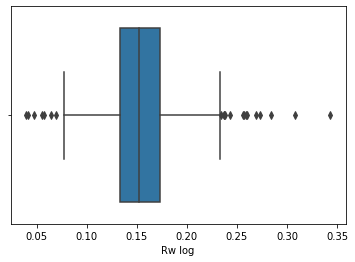

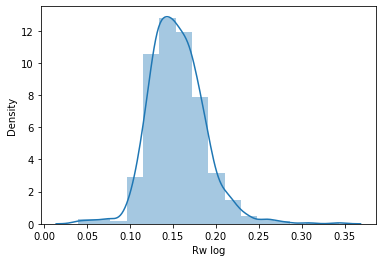

In [18]:
#visualize using histogram, boxplot, etc
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(logging['Rw log'])
plt.show()

sns.distplot(logging['Rw log'], bins=16)
plt.show()

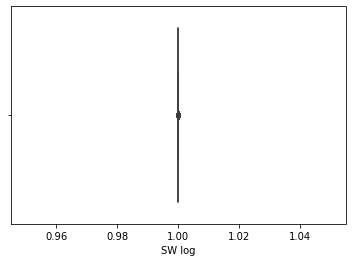

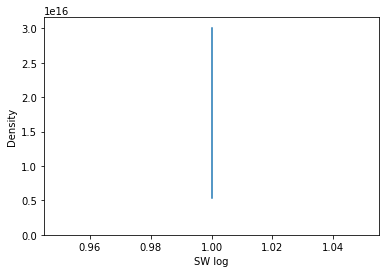

In [106]:
sns.boxplot(logging['SW log'])
plt.show()

sns.distplot(logging['SW log'])
plt.show()